Borough Name: Manhattan
Borough Name: Queens
Borough Name: Bronx
Borough Name: Brooklyn
Borough Name: Unknown
Borough Name: Staten Island
Borough Name: EWR


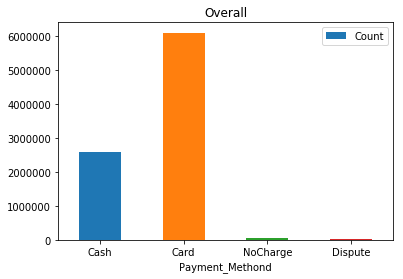

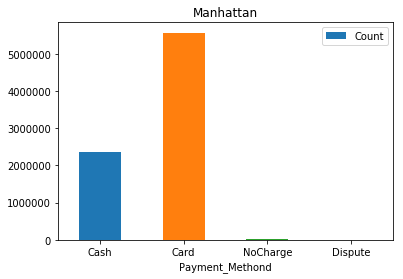

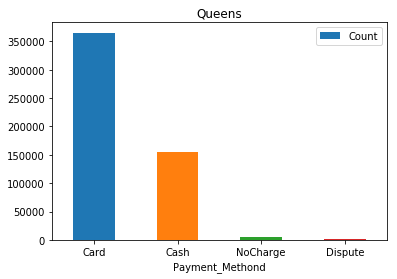

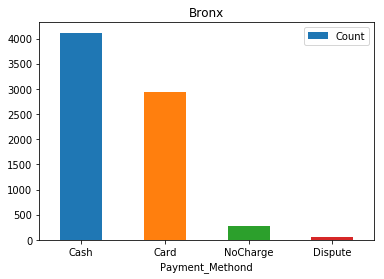

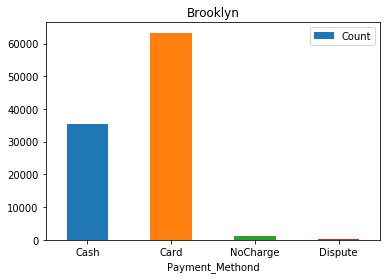

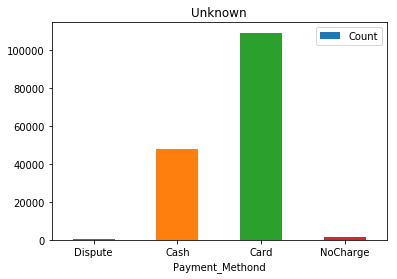

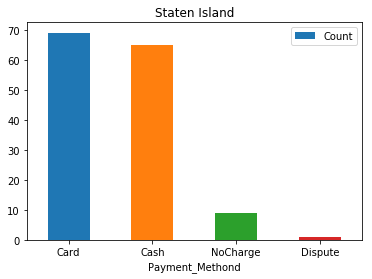

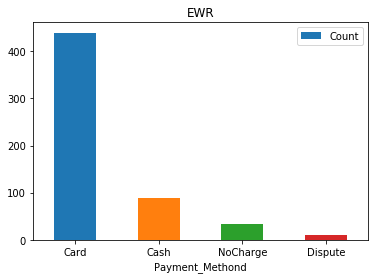

In [115]:
# Load the Pandas libraries with alias 'pd' 
import pandas as pd 
from sqlalchemy import create_engine
import os as os
from datetime import datetime
import traceback
from enum import Enum
%matplotlib inline

#class this will be on seperate file
class EachMonthTrips:
    payments_count = {}
    payments_count_for_each_borough = {}

#Enum
class Payment_Types(Enum):
    Card = 1
    Cash = 2
    NoCharge = 3
    Dispute = 4
    Unknown = 5
    Voided = 6
   
    
#filesname variables
yellow_tripdata_2018 = 'yellow_tripdata_2018-01'
taxi_zone_lookup = 'taxi_zone_lookup.csv'

#This function will generate the chunk and yeild it where it is demanded
def chunck_generator(filename, header=False,chunk_size = 10 ** 5): # notice the default value for chunk_size and header
    for chunk in pd.read_csv(filename,delimiter=',', iterator=True, chunksize=chunk_size, parse_dates=[1] ): 
        yield (chunk)
        
#This function will also used for generating the chunk but it will yeild out the single row which being used for calculation
def _generator( filename, header=False,chunk_size = 10 ** 5): # notice the default value for chunk_size and header
    chunk = chunck_generator(filename, header=False,chunk_size = 10 ** 5)
    for row in chunk: #go over the chunk file and loop through rows and yeild them
        yield row

#This function will be used to read zone_lookup file
def read_full_csv_file(zone_lookup):
    df = pd.read_csv(zone_lookup)
    return df 


#combinning the data with zone    
def combine_file_with_zone(tripdata_filename, zone_lookup, list_of_months):
    filename = tripdata_filename
    generator = _generator(filename=filename)
    
    continue_iteration = True # this will make iteration to stop
    
            
    index=0;      
    while continue_iteration:
        try:
            yellow_tripdata_chunk = next(generator)
            taxi_zone_data_set = read_full_csv_file(taxi_zone_lookup)
            if isinstance(yellow_tripdata_chunk, pd.DataFrame) and isinstance(taxi_zone_data_set, pd.DataFrame):
                combined_data_set = pd.merge(yellow_tripdata_chunk, taxi_zone_data_set, on= None, left_on = 'PULocationID', right_on = 'LocationID')
                 #finding answers

            for index, row in combined_data_set.iterrows(): # iterating through dataframe
                date = row["tpep_pickup_datetime"] # It is already in DateTime format. Great!
                month_name = '%02d' % date.month #getting month name
                try:
                    payment_method_name = Payment_Types(row["payment_type"]).name
                    if (payment_method_name not in list_of_months[month_name].payments_count):
                        list_of_months[month_name].payments_count[payment_method_name] = 0
                    list_of_months[month_name].payments_count[payment_method_name] = list_of_months[month_name].payments_count[payment_method_name] + 1 
                    if row["Borough"] not in list_of_months[month_name].payments_count_for_each_borough:
                        list_of_months[month_name].payments_count_for_each_borough[row["Borough"]]={}
                    borough_item = list_of_months[month_name].payments_count_for_each_borough[row["Borough"]]
                    if payment_method_name not in borough_item:
                        borough_item[payment_method_name] = 0
                    borough_item[payment_method_name] = borough_item[payment_method_name] + 1
                except Exception as e:
                    pass 
        except Exception as e:
            continue_iteration=False
            pass
        
        
# now I am going to assume that data I have is for 2018
list_of_months = {"01":EachMonthTrips()}

# assigning value to each object of list_of_months for dictionary purposes
        
borough_df = read_full_csv_file(taxi_zone_lookup)

list_of_unqiue_boroughs = borough_df.Borough.unique() #getting and droping unknown borough

files = os.listdir(os.curdir)  #files and directories
index=0
files.reverse()
for filename in files:
    if yellow_tripdata_2018 in filename:
        combine_file_with_zone(filename,taxi_zone_lookup,list_of_months)
        index = index + 1

        
pyments_count_for_jan = list_of_months['01'].payments_count        

data_frame_to_plot = pd.DataFrame({'Payment_Methond':list( pyments_count_for_jan.keys()), 'Count': list(pyments_count_for_jan.values())})
data_frame_to_plot.plot.bar(x='Payment_Methond', y='Count', rot=0,title="Overall")

for borough_key, borough_value in list_of_months['01'].payments_count_for_each_borough.items():
    print("Borough Name: " + borough_key)
    data_frame_to_plot = pd.DataFrame({'Payment_Methond':list( borough_value.keys()), 'Count': list(borough_value.values())})
    data_frame_to_plot.plot.bar(x='Payment_Methond', y='Count', rot=0,title=borough_key)

        

# What is the most common way of payments? 

The most common way of payment is by using Credit Card as you can see in first graph


# Discover the way payments are executed in each borough and visualise the number of payments for any possible means

I have visualized the information above so to post above details here. 

1. Manhattan - Credit Card
2. Queens - Credit Card
3. Bronx - Cash
4. Brooklyn - Card
5. Unkown - Card
6. EWR - Card
6. Staten - Card

In [116]:
import numpy
import scipy.stats as stats
chi_square_frame_payments_count_for_each_borough = list_of_months['01'].payments_count_for_each_borough;

# for making the for 5 categories of different payments type we have to add Unknown payment method as well
try:
    for borough_key, borough_value in chi_square_frame_payments_count_for_each_borough.items():
        for payment_type_key, payment_type_value in borough_value.items():
            payment_type_value["Unknown"] = 0
except Exception as e:
    pass

# For applying the chi-square test for need to test only Manhattan and Queens as cateory 

manhattan_dic = chi_square_frame_payments_count_for_each_borough["Manhattan"]
manhattan_df = pd.DataFrame({'Name': list( manhattan_dic.keys()),'Value' : list(manhattan_dic.values())})

queens_dic = chi_square_frame_payments_count_for_each_borough["Queens"]
queens_df = pd.DataFrame({'Name':list(queens_dic.keys()),'Value':list(queens_dic.values())})

manhattan_table = manhattan_df
queens_table = queens_df


print( "Manhattan")
print(manhattan_table)
print(" ")
print( "Queens")
print(queens_table)




Manhattan
       Name    Value
0      Cash  2356781
1      Card  5564631
2  NoCharge    34240
3   Dispute     9762
 
Queens
       Name   Value
0      Card  365199
1      Cash  154698
2  NoCharge    5697
3   Dispute    1298


In [117]:
#Chi-squared tests are based on the so-called chi-squared statistic. You calculate the chi-squared statistic with the following formula:
#sum((observed−expected)2expected
#In the formula, observed is the actual observed count for each category and expected is the expected count based on the distribution of the population for the corresponding category. Let's calculate the chi-squared statistic for our data to illustrate:

observed = queens_table.Value
manhattan_ratio = manhattan_table.Value/sum(manhattan_table.Value) # Get population ratios
expected = manhattan_ratio * sum(queens_table.Value)   # Get expected counts
chi_squared_stat = (((observed-expected)**2)/expected).sum()



In [118]:
crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 4)   # Df = number of variable categories - 1

print("Critical value")
print(crit)

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat,  # Find the p-value
                             df=4)
print("P value")
print(p_value)

Critical value
9.487729036781154
P value
0.0


In [119]:
stats.chisquare(f_obs= observed,   # Array of observed counts
                f_exp= expected)   # Array of expected counts

Power_divergenceResult(statistic=410576.17459391645, pvalue=0.0)

In [ ]:
#Note: I have used this link for chi-square test as reference : http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-25-chi.html